In [1]:
import os
import time
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend as K
%matplotlib inline
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow import keras

In [13]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [14]:
img_height, img_width = 256, 256
batch_size = 128

In [17]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/home/aditya/VAE/cartoonset100k/',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode=None)

Found 100000 files belonging to 10 classes.


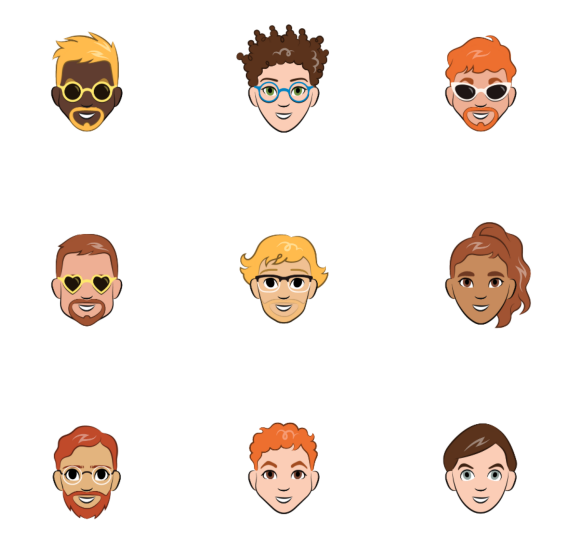

In [4]:
plt.figure(figsize=(10, 10))
for images in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [18]:
normalization_layer = layers.experimental.preprocessing.Rescaling(scale= 1./255)

In [19]:
normalized_ds = train_ds.map(lambda x: normalization_layer(x))
image_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [20]:
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [21]:
input_encoder = (256, 256, 3)
input_decoder = (200,)

In [22]:
def encoder(input_encoder):
    
    
    inputs = keras.Input(shape=input_encoder, name='input_layer')
    x = layers.Conv2D(32, kernel_size=3, strides= 2, padding='same', name='conv_1')(inputs)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
    
    x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
    
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)

    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)
    
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_5')(x)
    x = layers.BatchNormalization(name='bn_5')(x)
    x = layers.LeakyReLU(name='lrelu_5')(x)
   
    
    flatten = layers.Flatten()(x)
    bottleneck = layers.Dense(200, name='dense_1')(flatten)
    model = tf.keras.Model(inputs, bottleneck, name="Encoder")
    return model

In [23]:
enc = encoder(input_encoder)

In [24]:
#enc.save('enc.h5')

In [25]:
enc.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 128, 128, 32)      128       
_________________________________________________________________
lrelu_1 (LeakyReLU)          (None, 128, 128, 32)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 64, 64, 64)        18496     
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 64, 64, 64)        256       
_________________________________________________________________
lrelu_2 (LeakyReLU)          (None, 64, 64, 64)        0   

In [26]:
def decoder(input_decoder):
    
    inputs = keras.Input(shape=input_decoder, name='input_layer')
    x = layers.Dense(4096, name='dense_1')(inputs)
    #x = tf.reshape(x, [-1, 8, 8, 64], name='Reshape_Layer')
    x = layers.Reshape((8,8,64), name='Reshape_Layer')(x)
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same',name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
  
    
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
   
    
    x = layers.Conv2DTranspose(64, 3, 2, padding='same', name='conv_transpose_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
  
    
    x = layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)
   
  
    
    outputs = layers.Conv2DTranspose(3, 3, 2,padding='same', activation='sigmoid', name='conv_transpose_5')(x)
    model = tf.keras.Model(inputs, outputs, name="Decoder")
    return model

In [27]:
dec = decoder(input_decoder)

In [28]:
dec.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 200)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              823296    
_________________________________________________________________
Reshape_Layer (Reshape)      (None, 8, 8, 64)          0         
_________________________________________________________________
conv_transpose_1 (Conv2DTran (None, 16, 16, 64)        36928     
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 16, 16, 64)        256       
_________________________________________________________________
lrelu_1 (LeakyReLU)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv_transpose_2 (Conv2DTran (None, 32, 32, 64)        3692

In [16]:
#dec.save('ae-cartoon-dec.h5')

In [18]:
#model.layers[1].get_weights()

In [18]:
#model.save('autoencoder.h5')

In [19]:
optimizer = tf.keras.optimizers.Adam(lr = 0.0005)

In [20]:
def ae_loss(y_true, y_pred):
    #loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    #loss = tf.reduce_mean(tf.square(tf.subtract(y_true, y_pred)))
    loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    return loss

In [21]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):

    with tf.GradientTape() as encoder, tf.GradientTape() as decoder:
      
        latent = enc(images, training=True)
        generated_images = dec(latent, training=True)
        loss = ae_loss(images, generated_images)
        
    gradients_of_enc = encoder.gradient(loss, enc.trainable_variables)
    gradients_of_dec = decoder.gradient(loss, dec.trainable_variables)
    
    
    optimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
    return loss

In [22]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        i = 0
        loss_ = []
        for image_batch in dataset:
            i += 1
            loss = train_step(image_batch)
            #loss_.append(loss)

        #print("Loss",np.mean(loss_))    
        seed = image_batch[:25]
        display.clear_output(wait=True)
        generate_and_save_images([enc,dec],
                                  epoch + 1,
                                  seed)
        # Save the model every 15 epochs
        #if (epoch + 1) % 15 == 0:
        #checkpoint.save(file_prefix = checkpoint_prefix)
        enc.save_weights('tf_ae/cartoon/training_weights/enc_'+ str(epoch)+'.h5')
        dec.save_weights('tf_ae/cartoon/training_weights/dec_'+ str(epoch)+'.h5')
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images([enc,final,dec],
                            epochs,
                            seed)

In [23]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    latent = enc(test_input, training=False)
    predictions = dec(latent, training=False)
    print(predictions.shape)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        pred = predictions[i, :, :, :] * 255
        pred = np.array(pred)  
        pred = pred.astype(np.uint8)
        #cv2.imwrite('tf_ae/images/image'+ str(i)+'.png',pred)
        
        plt.imshow(pred)
        plt.axis('off')

    plt.savefig('tf_ae/cartoon/images/image_at_epoch_{:d}.png'.format(epoch))
    plt.show()
    

    

In [ ]:
train(normalized_ds, 30)

In [30]:
enc.load_weights('../tf_ae/cartoon/training_weights/enc_29.h5')

In [31]:
dec.load_weights('../tf_ae/cartoon/training_weights/dec_29.h5')

In [23]:
embeddings = None
for i in normalized_ds:
    latent = enc.predict(i)
    if embeddings is None:
        embeddings = latent
    else:
        embeddings = np.concatenate((embeddings, latent))
    if embeddings.shape[0] > 5000:
        break

In [20]:
embeddings.shape

(128, 200)

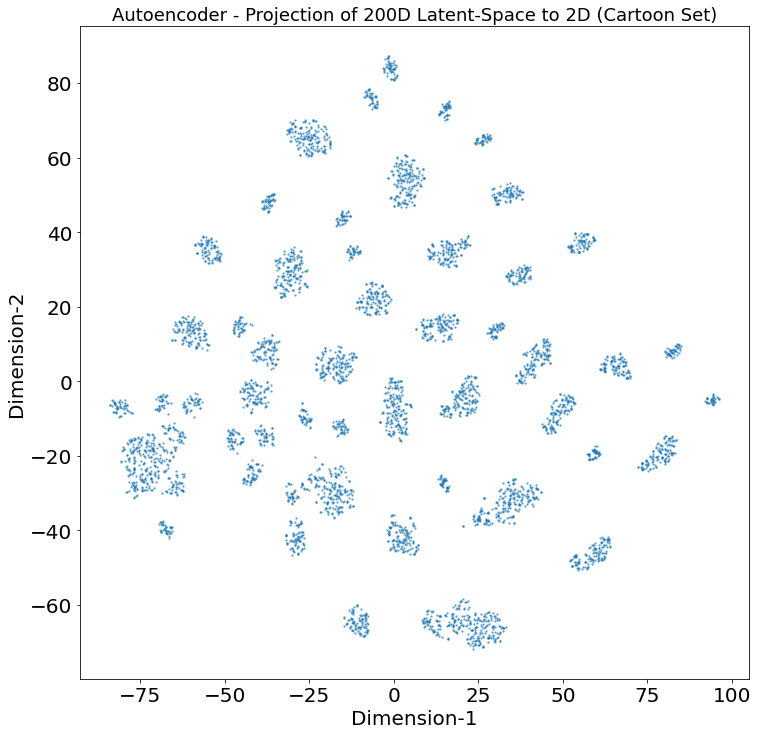

In [24]:
n_to_show = 5000
grid_size = 15
figsize = 12

tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(embeddings)
min_x = min(X_tsne[:, 0])
max_x = max(X_tsne[:, 0])
min_y = min(X_tsne[:, 1])
max_y = max(X_tsne[:, 1])


plt.figure(figsize=(figsize, figsize))
plt.scatter(X_tsne[:, 0] , X_tsne[:, 1], alpha=0.5, s=2)
plt.xlabel("Dimension-1", size=20)
plt.ylabel("Dimension-2", size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("Autoencoder - Projection of 200D Latent-Space to 2D (Cartoon Set)", size=18)
plt.show()

In [18]:
reconstruction = None
lat_space = None
for i in normalized_ds:
    latent= enc.predict(i)
    out = dec.predict(latent)
    if reconstruction is None:
        reconstruction = out
        lat_space = latent
    else:
        reconstruction = np.concatenate((reconstruction, out))
        lat_space = np.concatenate((lat_space, latent))
    if reconstruction.shape[0] > 5000:
        break

In [22]:
reconstruction.shape

(5120, 256, 256, 3)

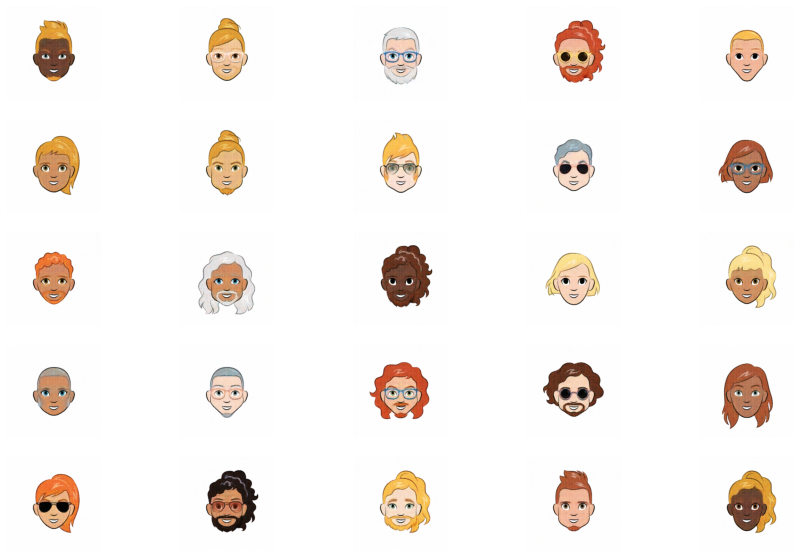

In [24]:
figsize = 15

fig = plt.figure(figsize=(figsize, 10))
#fig.subplots_adjust(hspace=0.2, wspace=None)

for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruction[i, :, :, :] * 255
    pred = np.array(pred)  
    pred = pred.astype(np.uint8)
    ax.imshow(pred)

### Reconstructing Cartoon Images with Latent-Vector Sampled Uniformly

(10, 200)


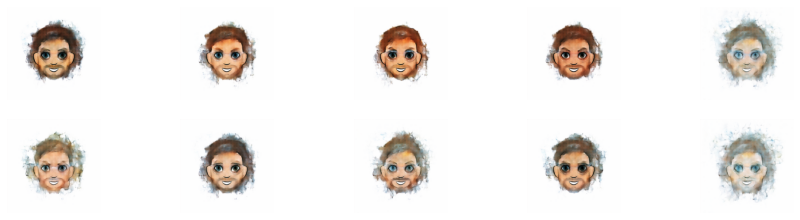

In [46]:
figsize = 15

min_x = lat_space.min(axis=0)
max_x = lat_space.max(axis=0)
# #print(max_x.shape, min_x.shape)
x = np.random.uniform(size = (10,200))
x = x * (max_x - (np.abs(min_x))) 
print(x.shape)
#x = np.random.normal(size = (10,200))
reconstruct = dec.predict(x)


fig = plt.figure(figsize=(figsize, 10))

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruct[i, :, :, :] * 255
    pred = np.array(pred)  
    pred = pred.astype(np.uint8)
    ax.imshow(pred)

## Reconstructing Cartoon Images from a Latent-Vector Sampled with Normal Distribution

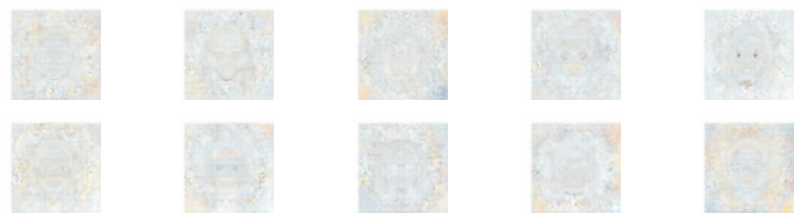

In [32]:
x = np.random.normal(size = (10,200))
reconstruct = dec.predict(x)

fig = plt.figure(figsize=(15, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruct[i, :, :, :] * 255
    pred = np.array(pred)  
    pred = pred.astype(np.uint8)
    ax.imshow(pred)